# Import Data

In [305]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize


from sklearn.decomposition import PCA

In [306]:
import seaborn as sns
sns.set()

In [307]:
def create_confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None, display_labels=None,
                           include_values=True, xticks_rotation='horizontal', values_format=None,
                           cmap='viridis', ax=None, colorbar=True):
    
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [308]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [309]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1

    return TP/(TP+FP)

In [310]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [311]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [312]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = []

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0   
    
    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

In [313]:
#df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/binary/wnt_rest.xlsx")
df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/4way/mb_t1_t2_4way.xlsx")

# RF1 -> NN2

In [331]:
first_target = df["molecular"]

In [332]:
first_target.value_counts()

shh      83
type4    64
type3    48
wnt      26
Name: molecular, dtype: int64

In [333]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/binary/binary_reduced.xlsx")

In [334]:
reduced_features_list = reduced_features.loc[reduced_features['wnt_rest'].isnull() == False, ['wnt_rest']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [335]:
first_target = first_target.map(dict(wnt = 0, shh = 1, type3 = 1, type4 = 1))

In [336]:
first_features = df[reduced_features_list]

In [337]:
sex_binarized = first_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

first_features['sex'] = sex_binarized

<ipython-input-337-7abfed4242db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_features['sex'] = sex_binarized


In [338]:
first_features.head()

,sex,age,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-1-mm-3D_glcm_InverseVariance,t1_log-sigma-1-mm-3D_glcm_MCC,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniformityNormalized,t1_log-sigma-5-mm-3D_firstorder_Skewness,t1_wavelet-HHL_firstorder_Median,t1_wavelet-HLH_firstorder_Skewness,...,t2_log-sigma-5-mm-3D_firstorder_90Percentile,t2_log-sigma-5-mm-3D_glrlm_RunEntropy,t2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis,t2_wavelet-LHL_glcm_InverseVariance,t1_log-sigma-5-mm-3D_firstorder_Median,t1_wavelet-HHH_glcm_ClusterShade,t2_log-sigma-3-mm-3D_firstorder_Median,t2_wavelet-LHL_firstorder_Energy,t2_wavelet-LHH_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-HHL_firstorder_Energy
0,0,79.0,0.505918,0.456103,0.562873,0.009914,0.151307,0.745832,-0.008154,0.027467,...,-3.319491,5.205622,381.588056,0.413472,-21.023060,0.002760,-9.091005,7.855152e+06,0.775000,2.039729e+06
1,0,90.0,0.432892,0.432303,0.475984,0.102841,0.375000,-0.423881,-0.033418,0.127864,...,-2.592589,4.949568,188.395559,0.375094,-13.636353,0.011874,-23.093743,1.776711e+06,0.625000,9.030103e+05
2,0,76.0,0.507732,0.467495,0.534334,0.003729,0.143779,0.266144,-0.174364,0.068410,...,-8.626585,5.409242,210.395917,0.309880,-16.443489,0.000162,-15.260113,2.753361e+07,0.785714,5.791610e+06
3,0,121.0,0.469566,0.359673,0.506549,0.031691,0.314129,0.393157,0.092495,-0.137343,...,-13.716932,4.941416,100.589683,0.456882,1.676658,0.001026,-16.307477,1.583997e+06,0.625000,3.200592e+05
4,0,27.0,0.577000,0.457465,0.591460,0.005969,0.099021,0.156855,-0.127051,0.036008,...,4.093615,5.118160,312.123409,0.325784,-39.815252,0.000574,-2.067522,8.533643e+06,0.358333,4.353275e+06


In [339]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_features, first_target, 
                                                   test_size = 0.25, random_state = 42)

In [340]:
y_train_1.value_counts()

1    147
0     18
Name: molecular, dtype: int64

In [341]:
y_test_1.value_counts()

1    48
0     8
Name: molecular, dtype: int64

In [342]:
first_X = pd.concat([X_train_1, y_train_1], axis = 1)
first_X_0 = first_X[first_X['molecular'] == 0]
first_X_1 = first_X[first_X['molecular'] == 1]

In [343]:
upsampled_0 = resample(first_X_0, replace = True, n_samples = len(first_X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, first_X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [344]:
X_train_1 = upsampled.iloc[:, :-1]
y_train_1 = upsampled.iloc[:, -1]

In [345]:
y_train_1.value_counts()

1    147
0    147
Name: molecular, dtype: int64

In [346]:
##doess this need to be binarized...

y_train_bin = label_binarize(y_train_1, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test_1, classes = [0, 1, 2])

y_train_1 = y_train_bin[:, 1]
y_test_1 = y_test_bin[:, 1]

In [347]:
names = X_train_1.columns
first_scaler = preprocessing.StandardScaler()

# RF1: wnt vs rest1

In [348]:
X_train_1 = first_scaler.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(X_train_1, columns = names)

X_test_1 = first_scaler.transform(X_test_1)
X_test_1 = pd.DataFrame(X_test_1, columns = names)

In [349]:
rf_seq_1_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_seq_1_grid = GridSearchCV(estimator=rf_seq_1_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [350]:
rf_seq_1_grid.fit(X_train_1, y_train_1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [351]:
print(rf_seq_1_grid.best_params_)

{'max_depth': 4, 'n_estimators': 100}


In [352]:
rf_seq_1_model = RandomForestClassifier(max_depth = 4, n_estimators = 100, random_state = 42)
rf_seq_1_model.fit(X_train_1, y_train_1)
y_pred_1 = rf_seq_1_model.predict(X_test_1)

In [390]:
y_pred_1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [353]:
print("Accuracy Score: " + str(accuracy_score(y_test_1, y_pred_1)))
#print("Specificity Score: " + str(specificity_score(y_test_1.to_numpy(), y_pred_1)))
print("Precision: " + str(precision_score(y_test_1, y_pred_1)))
print("Recall: " + str(recall_score(y_test_1, y_pred_1)))
print("F1 Score: " + str(f1_score(y_test_1, y_pred_1)))

#print("PPV Score: " + str(positive_pv_score(y_test_1.to_numpy(), y_pred_1)))
#print("NPV Score: " + str(negative_pv_score(y_test_1.to_numpy(), y_pred_1)))

Accuracy Score: 0.875
Precision: 0.8867924528301887
Recall: 0.9791666666666666
F1 Score: 0.9306930693069307


# NN2 - [shh vs rest2] decomposed from rest1 

In [354]:
second_target = df["molecular"]

In [355]:
second_target.value_counts()

shh      83
type4    64
type3    48
wnt      26
Name: molecular, dtype: int64

In [356]:
second_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)

In [357]:
second_target = second_target.map(dict(shh = 0, wnt = -1, type3 = 1, type4 = 1))
second_target = second_target[second_target != -1]
second_features = second_features.iloc[second_target.index]

In [358]:
second_target.value_counts()

1    112
0     83
Name: molecular, dtype: int64

In [359]:
second_target = second_target.reset_index(drop = True)
second_features = second_features.reset_index(drop = True)

In [360]:
second_reduced_features_list = reduced_features.loc[reduced_features['2ndstage_shh_rest'].isnull() == False, ['2ndstage_shh_rest']].values.tolist()

In [361]:
second_reduced_features_list = [item for sublist in second_reduced_features_list for item in sublist]

In [362]:
second_features = second_features[second_reduced_features_list]

In [363]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_features, second_target, 
                                                    test_size = 0.25, random_state = 42)

In [364]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['molecular'] == 0]
second_X_1 = second_X[second_X['molecular'] == 1]

In [365]:
second_upsampled_0 = resample(second_X_0, replace = True, n_samples = len(second_X_1), random_state = 42)
second_upsampled = pd.concat([second_upsampled_0, second_X_1])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [366]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]

In [367]:
second_names = X_train_2.columns
second_scaler = preprocessing.StandardScaler()

In [368]:
X_train_2 = second_scaler.fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns = second_names)

In [369]:
X_test_2 = second_scaler.transform(X_test_2)
X_test_2 = pd.DataFrame(X_test_2, columns = second_names)

In [370]:
nn_seq_2_model = MLPClassifier(hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)

In [371]:
nn_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = nn_seq_2_model.predict(X_test_2)

In [372]:
accuracy_score(y_test_2, y_pred_2)

0.673469387755102

In [373]:
print("Accuracy Score: " + str(accuracy_score(y_test_2, y_pred_2)))
print("Specificity Score: " + str(specificity_score(y_test_2.to_numpy(), y_pred_2)))
print("Precision: " + str(precision_score(y_test_2, y_pred_2)))
print("Recall: " + str(recall_score(y_test_2, y_pred_2)))
print("F1 Score: " + str(f1_score(y_test_2, y_pred_2)))

print("PPV Score: " + str(positive_pv_score(y_test_2.to_numpy(), y_pred_2)))
print("NPV Score: " + str(negative_pv_score(y_test_2.to_numpy(), y_pred_2)))

Accuracy Score: 0.673469387755102
Specificity Score: 0.5909090909090909
Precision: 0.6896551724137931
Recall: 0.7407407407407407
F1 Score: 0.7142857142857143
PPV Score: 0.6896551724137931
NPV Score: 0.65


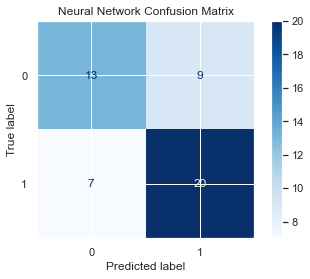

In [374]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

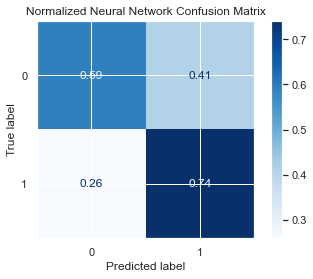

In [375]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# Testing

In [587]:
test_features = df.drop(['molec_id','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1) 
test_target = df["molecular"]

In [588]:
test_features

,molecular,sex,age,t1_log-sigma-1-mm-3D_firstorder_10Percentile,t1_log-sigma-1-mm-3D_firstorder_90Percentile,t1_log-sigma-1-mm-3D_firstorder_Energy,t1_log-sigma-1-mm-3D_firstorder_Entropy,t1_log-sigma-1-mm-3D_firstorder_InterquartileRange,t1_log-sigma-1-mm-3D_firstorder_Kurtosis,t1_log-sigma-1-mm-3D_firstorder_Maximum,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,shh,F,79.0,-14.446979,8.570989,2.386692e+06,2.058784,11.399018,5.429111,67.647911,...,1.973686,0.000808,1027.170040,0.297042,0.562429,1220.949377,0.000601,7.518529,0.134000,5335.217376
1,wnt,F,90.0,-11.965873,5.527298,2.653529e+05,1.661074,9.179155,5.046659,46.801155,...,0.243711,0.005756,344.000989,0.340258,0.604408,481.129194,0.004316,7.318544,0.252624,209.948818
2,wnt,F,76.0,-15.311574,12.145382,4.502164e+06,2.288427,13.547600,7.190374,57.708969,...,0.049205,0.000786,4051.276393,0.385322,0.644380,1826.940136,0.000552,8.163314,0.350257,66.167310
3,type4,F,121.0,-6.059545,6.715712,3.960594e+05,1.354158,6.443654,4.655418,21.968809,...,3.112323,0.003300,481.319732,0.321953,0.586631,463.640209,0.002341,7.438314,0.129236,2106.125227
4,shh,F,27.0,-25.161749,9.990795,4.884253e+06,2.589809,17.211576,4.150726,56.228771,...,0.094180,0.001028,1305.932045,0.382523,0.642779,1897.521463,0.000611,7.748172,0.291049,174.711614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,shh,M,22.0,-27.907258,15.962589,1.493149e+07,2.931215,19.929533,5.994240,116.221512,...,1.211945,0.000565,3764.525654,0.387856,0.646073,2209.516014,0.000413,7.867412,0.257590,2245.267377
217,wnt,M,172.0,-16.559532,10.121233,4.474797e+06,2.233474,13.508543,4.313261,52.201164,...,2.395014,0.001504,1891.628493,0.324298,0.589271,825.808563,0.001061,7.623581,0.181374,2622.388341
218,type4,M,74.0,-34.380056,23.855227,1.014991e+07,3.273762,28.915231,3.845363,110.470612,...,0.624603,0.001676,1620.801636,0.323449,0.587494,651.778314,0.001052,7.619742,0.242852,478.635109
219,shh,M,14.0,-32.209457,25.601605,3.656453e+07,3.293817,27.997813,4.266583,119.978508,...,2.016422,0.000795,3300.903006,0.325372,0.588549,1307.124424,0.000533,7.851386,0.205148,2879.261041


In [589]:
test_target

0        shh
1        wnt
2        wnt
3      type4
4        shh
       ...  
216      shh
217      wnt
218    type4
219      shh
220    type4
Name: molecular, Length: 221, dtype: object

In [590]:
test_target = test_target.map(dict(wnt = 0, shh = 1, type3 = 1, type4 = 1))

In [591]:
test_target

0      1
1      0
2      0
3      1
4      1
      ..
216    1
217    0
218    1
219    1
220    1
Name: molecular, Length: 221, dtype: int64

In [592]:
X_train, X_test, y_train, y_test = train_test_split(test_features, test_target, 
                                                    test_size = 0.25, random_state = 42)

In [593]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [594]:
sex_binarized = X_test['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_test['sex'] = sex_binarized

In [595]:
X_test_reduced = X_test[reduced_features_list]

In [596]:
names = X_test_reduced.columns
X_test_for_first = first_scaler.transform(X_test_reduced)
X_test_for_first = pd.DataFrame(X_test_for_first, columns = names)

In [597]:
y_preds_after_first = rf_seq_1_model.predict(X_test_for_first)

In [598]:
y_preds_after_first

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [599]:
## changed  == 1 to == 0; pilo was previously '1'
wnt_indices = np.where(y_preds_after_first == 0)
other_indices = np.where(y_preds_after_first != 0)

In [600]:
#need to take these indices and relabel them
other_indices

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55]),)

In [601]:
df2 = X_test.iloc[other_indices]

In [602]:
test_target2 = df2["molecular"]

In [603]:
test_target2 = test_target2.map(dict(wnt = -1, shh = 0, type3 = 1, type4 = 1))

In [604]:
wnt_preds = y_preds_after_first[wnt_indices]
y_test_for_wnt = np.array(y_test)[wnt_indices]

In [608]:
#is this where test_target2 goes?
X_test_after_first_model = X_test.iloc[other_indices].reset_index(drop = True)
y_test_after_first_model = y_test.iloc[other_indices].reset_index(drop = True)

In [606]:
y_test_after_first_model

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     0
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    0
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    0
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    0
39    0
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    0
Name: molecular, dtype: int64

In [585]:
X_test_after_first_model = X_test_after_first_model[second_reduced_features_list]

<ipython-input-585-a46c53551f90>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test_after_first_model = X_test_after_first_model[second_reduced_features_list]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [462]:
X_test_after_first_model = second_scaler.transform(X_test_after_first_model)

In [439]:
# X_test_after_first_model = second_scaler.transform(X_test_after_first_model)
# second_testprincipalComponents = second_pca.transform(X_test_after_first_model)
# X_test_after_first_model = pd.DataFrame(data = second_testprincipalComponents)

In [465]:
#y_test_after_first_model is those patients who were not selected for wnt
#relabel wnt from 0 to -1?
#need to decompose 1 back to shh and type3/4...

y_test_after_first_model = np.array(y_test_after_first_model)
y_test_after_first_model[y_test_after_first_model == 1] = -1
y_test_after_first_model[y_test_after_first_model == 2] = 1

In [441]:
y_preds_after_second = nn_seq_2_model.predict(X_test_after_first_model)

In [442]:
accuracy_score(y_test_after_first_model, y_preds_after_second)

0.03773584905660377

In [443]:
y_preds_after_second[y_preds_after_second == 1] = 2

In [260]:
y_test_after_first_model[y_test_after_first_model == 1] = 2
y_test_after_first_model[y_test_after_first_model == -1] = 1

In [261]:
y_preds_overall = np.concatenate([y_preds_after_second, wnt_preds])
y_test_overall = np.concatenate([y_test_after_first_model, y_test_for_wnt])

In [262]:
accuracy_score(y_test_overall, y_preds_overall)

0.32142857142857145

In [92]:
sns.reset_orig()

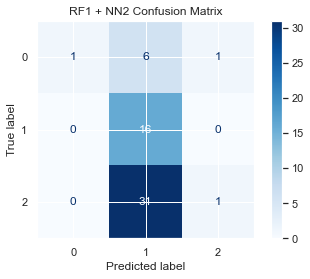

In [264]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues)
plt.title('RF1 + NN2 Confusion Matrix')
plt.show(matrix)
plt.show()

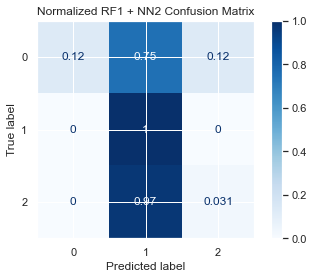

In [265]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues, normalize = 'true')
plt.title('Normalized RF1 + NN2 Confusion Matrix')
plt.show(matrix)
plt.show()

In [266]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_overall, y_preds_overall)

Specificities
0 1.0
1 0.075
2 0.9583333333333334
Macro Avg : 0.6777777777777777
Micro Avg : 0.6607142857142857 

PPV/Precision
0 1.0
1 0.3018867924528302
2 0.5
Macro Avg : 0.60062893081761
Micro Avg : 0.32142857142857145 

NPV
0 0.8727272727272727
1 1.0
2 0.42592592592592593
Macro Avg : 0.7662177328843995
Micro Avg : 0.6607142857142857 

Recall
0 0.125
1 1.0
2 0.03125
Macro Avg : 0.3854166666666667
Micro Avg : 0.32142857142857145 

F1 Score
0 0.2222222222222222
1 0.463768115942029
2 0.058823529411764705
Macro Avg : 0.46953690784665464
Micro Avg : 0.32142857142857145 

Accuracy:
0 0.875
1 0.3392857142857143
2 0.42857142857142855
Macro Avg : 0.5476190476190477
Micro Avg : 0.5476190476190477 



In [267]:
y_test_bin = label_binarize(y_test_overall, classes = [0, 1, 2])
y_pred_bin = label_binarize(y_preds_overall, classes = [0, 1, 2])

In [268]:
n_classes = 3

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test_overall), len(y_test_overall))
    if len(np.unique(y_test_overall[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    for i in range(n_classes):
        one_acc.append(accuracy_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_spec.append(specificity_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_prec.append(precision_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_rec.append(recall_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_f_one.append(f1_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##

    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ZeroDivisionError: division by zero

In [98]:
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the Accuracy score for class 0: [0.9179 - 0.9851]
95% Confidence interval for the Accuracy score for class 1: [0.8955 - 0.9776]
95% Confidence interval for the Accuracy score for class 2: [0.8955 - 0.9776]
95% Confidence interval for the Specificity score for class 0: [0.9358 - 1.0]
95% Confidence interval for the Specificity score for class 1: [0.9419 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.8472 - 0.9744]
95% Confidence interval for the Precision score for class 0: [0.7692 - 1.0]
95% Confidence interval for the Precision score for class 1: [0.8750 - 1.0]
95% Confidence interval for the Precision score for class 2: [0.8308 - 0.9701]
95% Confidence interval for the Recall score for class 0: [0.7778 - 1.0]
95% Confidence interval for the Recall score for class 1: [0.7568 - 0.9556]
95% Confidence interval for the Recall score for class 2: [0.9167 - 1.0]
95% Confidence interval for the F1 score for class 0: [0.8000 - 0.9677]
95% 